## 使用到的库

In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage import exposure
from skimage.exposure import match_histograms

## Color Transfer

In [3]:
class ColorTransfer(object):
    '''
    传入.bmp文件名列表(无后缀)source,target

    参数：
        sources:用于存储原图片的一个列表，其中的每一个元素均是一个RGB顺序的矩阵
        targets:用于存储目标图片的一个列表，其中的每一个元素均是一个RGB顺序的矩阵
        r1:用于存储Reinhard算法生成的迁移后的图片的一个列表，其中的每一个元素均是一个RGB顺序的矩阵
        r2:用于存储直方图匹配算法生成的迁移后的图片的一个列表，其中的每一个元素均是一个RGB顺序的矩阵
    '''
    def __init__(self, source, target):
        self.sources = []
        self.targets = []
        self.r1 = []
        self.r2 = []
        for i in range(len(source)):
            s,t = self.read_file(source[i], target[i])
            self.sources.append(cv2.cvtColor(s,cv2.COLOR_BGR2RGB))
            self.targets.append(cv2.cvtColor(t,cv2.COLOR_BGR2RGB))

    def read_file(self, sn, tn):
        '''
        读取图像
        '''
        s = cv2.imread('source/'+sn+'.bmp')
        t = cv2.imread('target/'+tn+'.bmp')
        return s, t
    
    def get_mean_and_std(self, x):
        '''
        获取均值和方差
        '''
        x_mean, x_std = cv2.meanStdDev(x)
        x_mean = np.hstack(np.around(x_mean, 2))
        x_std = np.hstack(np.around(x_std, 2))
        return x_mean, x_std
    
    def color_transfer(self):
        '''
        Reinhard算法
        '''
        print("Reinhard:")
        for n in range(len(self.sources)):
            print("    Converting picture"+str(n+1)+"...")
            s_ = cv2.cvtColor(self.sources[n], cv2.COLOR_RGB2LAB)
            t_ = cv2.cvtColor(self.targets[n], cv2.COLOR_RGB2LAB)
            r = s_
            
            s_mean, s_std = self.get_mean_and_std(s_)
            t_mean, t_std = self.get_mean_and_std(t_)

            height, width, channel = s_.shape
            for i in range(0, height):
                for j in range(0, width):
                    for k in range(0, channel):
                        x = r[i, j, k]
                        x = ((x-s_mean[k])*(t_std[k]/s_std[k]))+t_mean[k]
                        x = round(x)
                        # 检查边界情况
                        x = 0 if x < 0 else x
                        x = 255 if x > 255 else x
                        r[i, j, k] = x
            r = cv2.cvtColor(r, cv2.COLOR_LAB2RGB)
            self.r1.append(r)
    
    def HistogramMatching(self):
        '''
        直方图匹配算法
        '''
        print("HistogramMatching:")
        for n in range(len(self.sources)):
            print("    Converting picture"+str(n+1)+"...")
            r = match_histograms(cv2.cvtColor(self.sources[n],cv2.COLOR_RGB2BGR), cv2.cvtColor(self.targets[n],cv2.COLOR_RGB2BGR), channel_axis=-1)
            r = cv2.cvtColor(r, cv2.COLOR_BGR2RGB)
            self.r2.append(r)

    def Show(self):
        '''
        显示四幅图像
        '''
        for i in range(len(self.sources)):
            fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(13, 10),
                                        sharex=True, sharey=True)
            for aa in (ax1, ax2, ax3, ax4):
                aa.set_axis_off()
                
            ax1.imshow(self.targets[i])
            ax1.set_title('Reference')
            ax2.imshow(self.sources[i])
            ax2.set_title('Source')
            ax3.imshow(self.r1[i])
            ax3.set_title('Transfer')
            ax4.imshow(self.r2[i])
            ax4.set_title('Matched')

            plt.tight_layout()
            plt.show()

    def ShowDistribution(self,img):
        '''
        展示分布
        '''

        # 获取图像的红、绿、蓝通道
        red = img[:, :, 0]
        green = img[:, :, 1]
        blue = img[:, :, 2]

        plt.figure(dpi=200)
        plt.scatter(red.flatten(), green.flatten(), color='b',alpha=0.8, zorder=1, s=0.5, label='R-G', marker='s')
        plt.scatter(green.flatten(), blue.flatten(), color='g',alpha=0.8, zorder=2, s=0.5, label='G-B', marker='s')
        plt.scatter(blue.flatten(), red.flatten(), color='orange',alpha=0.8, zorder=3, s=0.5, label='B-R', marker='s')
        plt.legend(frameon=True, markerscale=10,loc='upper left')

        plt.show()


Reinhard:
    Converting picture1...
    Converting picture2...
    Converting picture3...
    Converting picture4...
    Converting picture5...
HistogramMatching:
    Converting picture1...
    Converting picture2...
    Converting picture3...
    Converting picture4...
    Converting picture5...


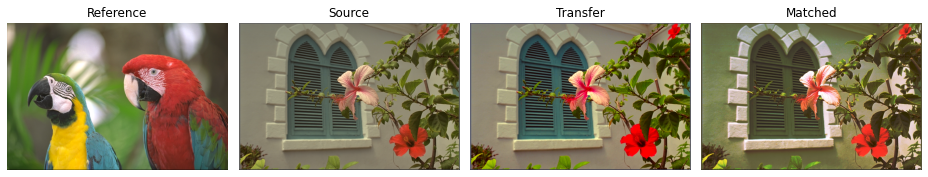

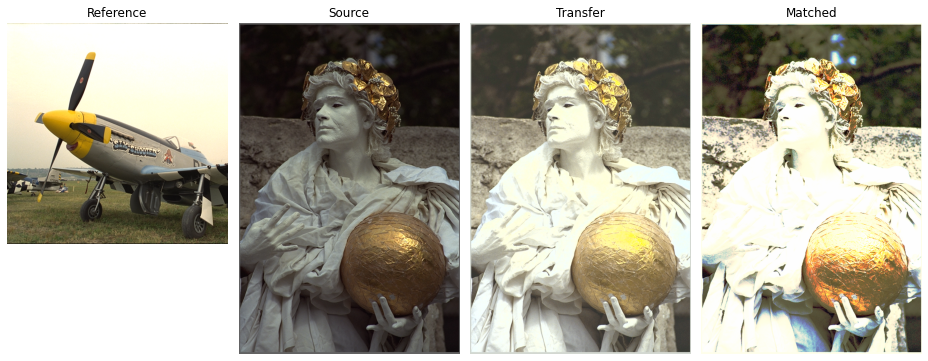

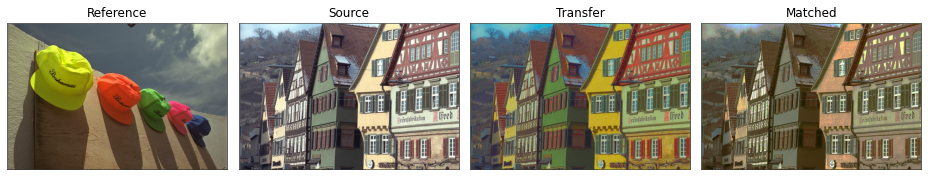

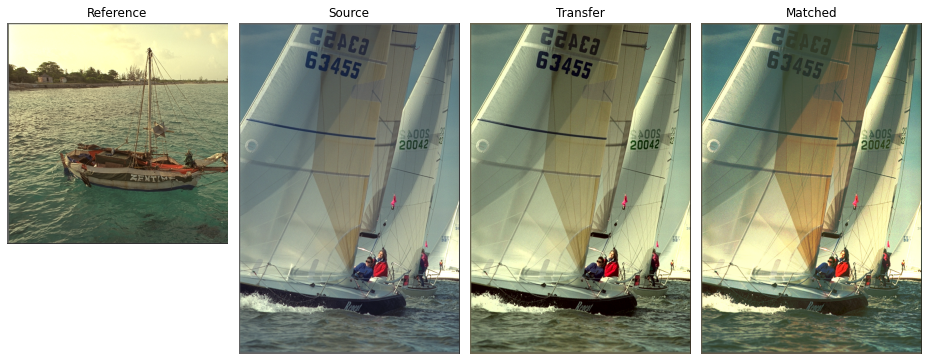

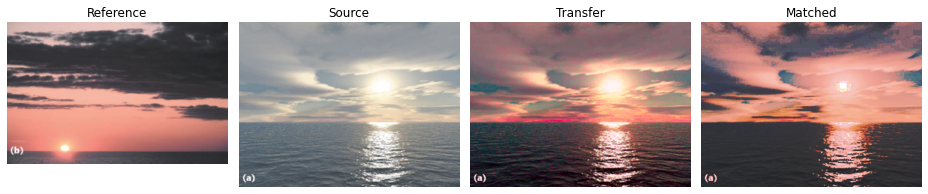

In [4]:
sources = ['s1','s2','s3','s4','s5']
targets = ['t1','t2','t3','t4','t5']
model = ColorTransfer(sources, targets)
model.color_transfer()
model.HistogramMatching()
model.Show()

### 分布图

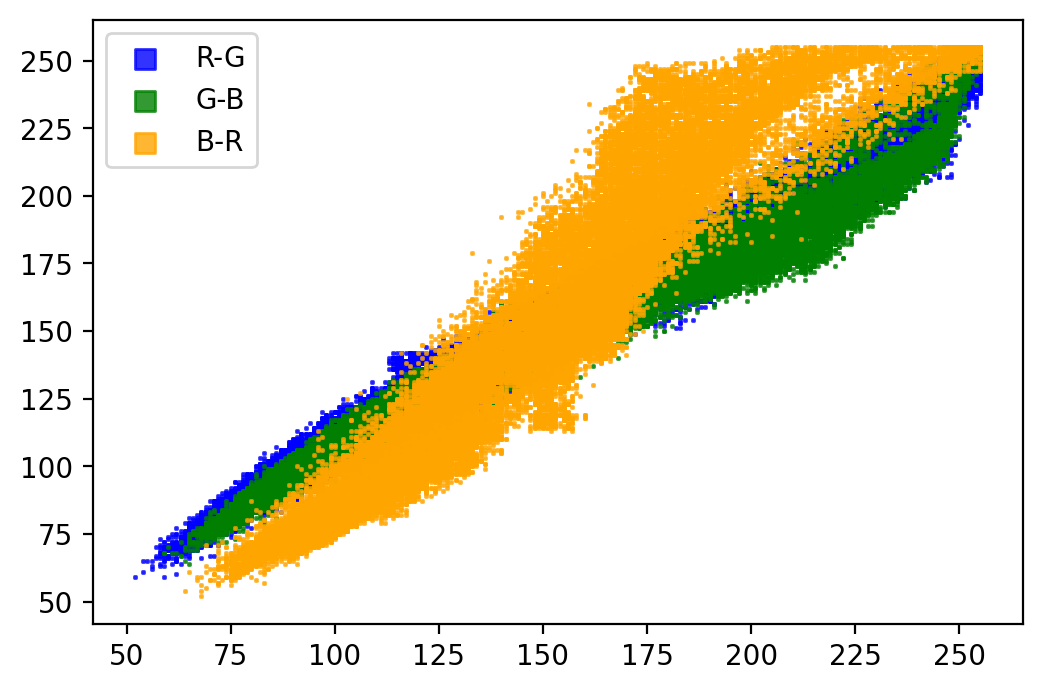

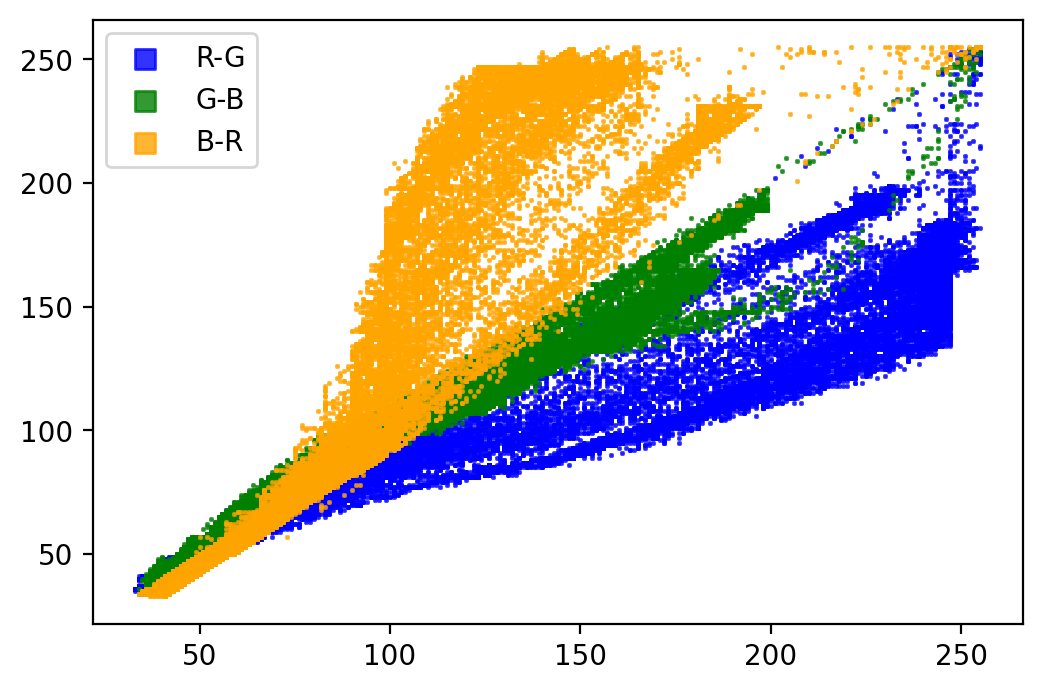

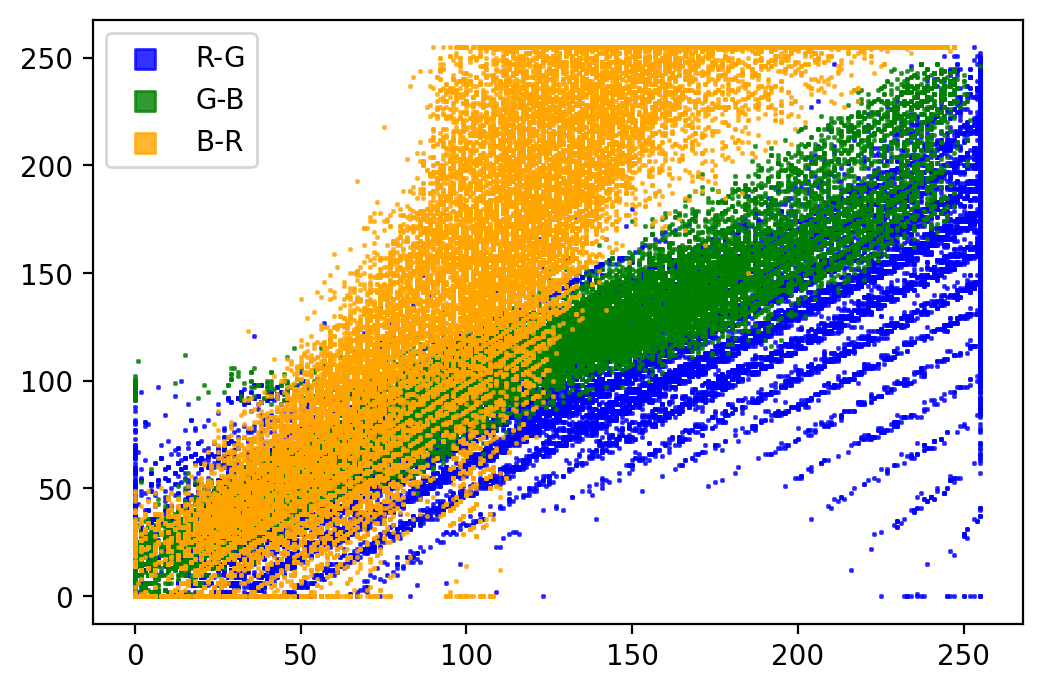

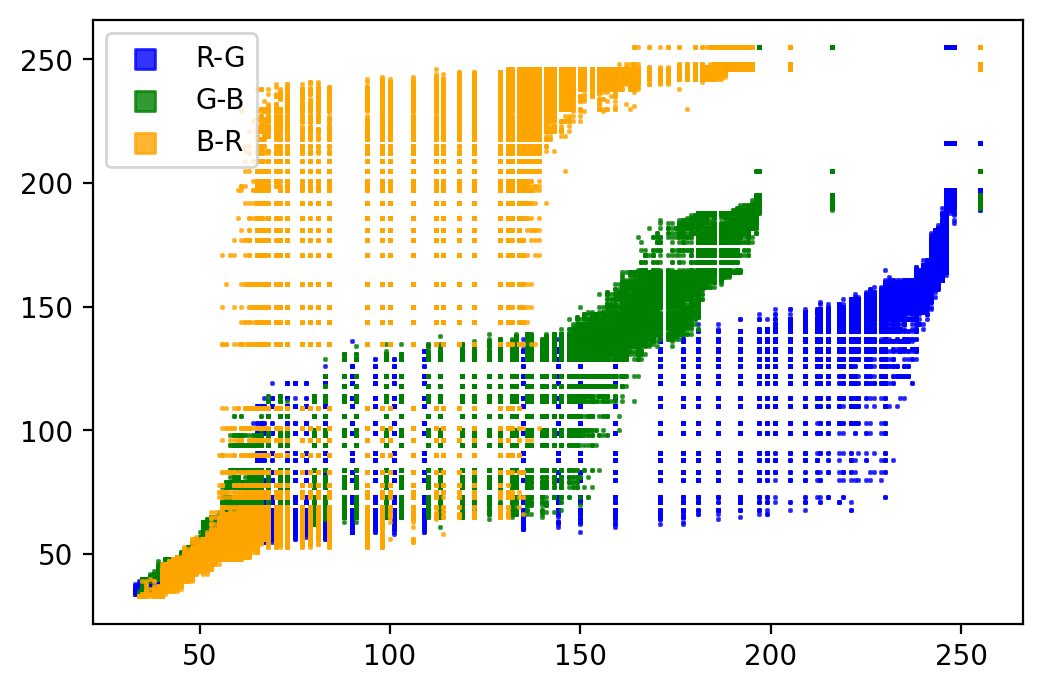

In [5]:
model.ShowDistribution(model.sources[4])
model.ShowDistribution(model.targets[4])
model.ShowDistribution(model.r1[4])
model.ShowDistribution(model.r2[4])

### 直方图

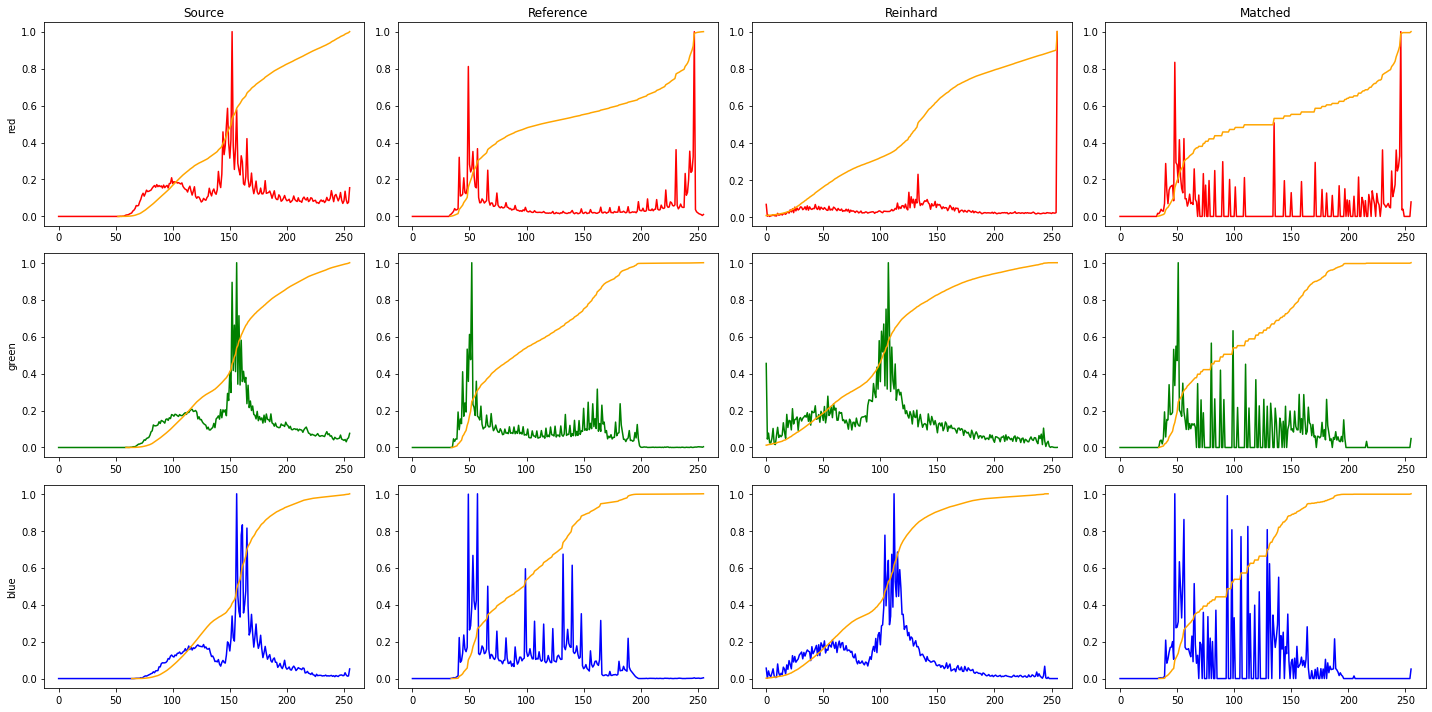

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 10))
color = ['r', 'g', 'b']
for i, img in enumerate((model.sources[4], model.targets[4], model.r1[4], model.r2[4])):
    for c, c_color in enumerate(('red', 'green', 'blue')):
        img_hist, bins = exposure.histogram(img[..., c], source_range='dtype')
        axes[c, i].plot(bins, img_hist / img_hist.max(), color[c])
        img_cdf, bins = exposure.cumulative_distribution(img[..., c])
        axes[c, i].plot(bins, img_cdf, color='orange')
        axes[c, 0].set_ylabel(c_color)

axes[0, 0].set_title('Source')
axes[0, 1].set_title('Reference')
axes[0, 2].set_title('Reinhard')
axes[0, 3].set_title('Matched')

plt.tight_layout()
plt.show()

## Histogram matching的手动实现

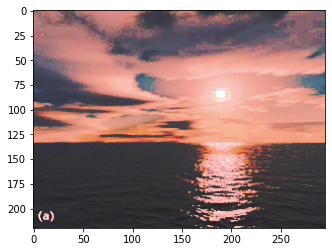

In [7]:
def his_match(src, dst):
    res = np.zeros_like(dst)
    # cdf 为累计分布
    cdf_src = np.zeros((3, 256))
    cdf_dst = np.zeros((3, 256))
    cdf_res = np.zeros((3, 256))
    kw = dict(bins=256, range=(0, 256), density=True)
    for ch in range(3):
        his_src, _ = np.histogram(src[:, :, ch], **kw)
        hist_dst, _ = np.histogram(dst[:, :, ch], **kw)
        cdf_src[ch] = np.cumsum(his_src)
        cdf_dst[ch] = np.cumsum(hist_dst)
        index = np.searchsorted(cdf_src[ch], cdf_dst[ch], side='left')
        np.clip(index, 0, 255, out=index)
        res[:, :, ch] = index[dst[:, :, ch]]
        his_res, _ = np.histogram(res[:, :, ch], **kw)
        cdf_res[ch] = np.cumsum(his_res)
    return res, (cdf_src, cdf_dst, cdf_res)


dst = cv2.imread('source/s5.bmp')
src = cv2.imread('target/t5.bmp')


res, cdfs = his_match(src, dst)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))